In [1]:
import pandas as pd
import os
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
network_attack_1 = pd.read_csv('../dataset/Network datatset/csv/attack_1.csv', sep=",")
network_attack_2 = pd.read_csv('../dataset/Network datatset/csv/attack_2.csv', sep=",")
network_attack_3 = pd.read_csv('../dataset/Network datatset/csv/attack_3.csv', sep=",")
network_attack_4 = pd.read_csv('../dataset/Network datatset/csv/attack_4.csv', sep=",")
network_normal = pd.read_csv('../dataset/Network datatset/csv/normal.csv', sep=",")

network_attack_1.name = "network_attack_1"
network_attack_2.name = "network_attack_2"
network_attack_3.name = "network_attack_3"
network_attack_4.name = "network_attack_4"
network_normal.name = "network_normal"

In [3]:
df_all = [network_attack_1, network_attack_2, network_attack_3, network_attack_4, network_normal]
def df_all_fn(func):
    df_all = [network_attack_1, network_attack_2, network_attack_3, network_attack_4, network_normal]
    for df in df_all:
        print(df.name)
        print("\n" + df.name + " -------------------------------------")
        func(df)

### Data cleaning

In [4]:
def shape(df):
    print(df.shape)

df_all_fn(shape)

network_attack_1

network_attack_1 -------------------------------------
(5527409, 16)
network_attack_2

network_attack_2 -------------------------------------
(5159469, 16)
network_attack_3

network_attack_3 -------------------------------------
(5862547, 16)
network_attack_4

network_attack_4 -------------------------------------
(5522490, 16)
network_normal

network_normal -------------------------------------
(7757289, 16)


In [5]:
# Some columns name begins with a space
network_attack_1.columns = network_attack_1.columns.str.strip()
network_attack_2.columns = network_attack_2.columns.str.strip()
network_attack_3.columns = network_attack_3.columns.str.strip()

# Transform the type of the label_n column and rename the column time to keep coherence
for i, df in enumerate(df_all):
    df_all[i]["label_n"] = df_all[i]["label_n"].astype(bool)
    df_all[i] = df_all[i].rename(columns = {'Time':'time'}, inplace= True)

# Validate that the columns are equals so that we can only print one of them
print(network_attack_1.columns.all()==network_attack_2.columns.all()==network_attack_3.columns.all()==network_attack_4.columns.all()==network_normal.columns.all())

print(network_attack_1.columns)

True
Index(['time', 'mac_s', 'mac_d', 'ip_s', 'ip_d', 'sport', 'dport', 'proto',
       'flags', 'size', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst',
       'modbus_response', 'label_n', 'label'],
      dtype='object')


In [6]:
network_attack_1.name = "network_attack_1"
network_attack_2.name = "network_attack_2"
network_attack_3.name = "network_attack_3"
network_attack_4.name = "network_attack_4"
network_normal.name = "network_normal"

In [7]:
# Print all attack labels to verify that none of them is gone
def attack_label(df):
    print(df["label"].unique())

df_all_fn(attack_label)

network_attack_1

network_attack_1 -------------------------------------
['normal' 'anomaly' 'MITM' 'physical fault']
network_attack_2

network_attack_2 -------------------------------------
['normal' 'anomaly' 'scan' 'DoS' 'physical fault' 'MITM']
network_attack_3

network_attack_3 -------------------------------------
['normal' 'physical fault' 'anomaly' 'DoS' 'MITM']
network_attack_4

network_attack_4 -------------------------------------
['normal' 'scan' 'DoS' 'physical fault' 'MITM']
network_normal

network_normal -------------------------------------
['normal']


In [8]:
# Checks which columns contains empty values
def check_cols(df):
    list_of_empty_cols = []
    df = df.isna()
    for col in df.columns:
        if df[col].max() != False:
            list_of_empty_cols.append(col)
    return list_of_empty_cols

In [9]:
# Before dropping empty values, see what they are because they can give some infos
# modbus contains interesting informations. We don't erase rows when there is a missing modbus.

cols_with_empty_values_df_1 = check_cols(network_attack_1)
cols_with_empty_values_df_2 = check_cols(network_attack_2)
cols_with_empty_values_df_3 = check_cols(network_attack_3)
cols_with_empty_values_df_4 = check_cols(network_attack_4)
cols_with_empty_values_df_normal = check_cols(network_normal)

print(cols_with_empty_values_df_1)
print(cols_with_empty_values_df_2)
print(cols_with_empty_values_df_3)
print(cols_with_empty_values_df_4)
print(cols_with_empty_values_df_normal)

['ip_s', 'ip_d', 'sport', 'dport', 'flags', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst', 'modbus_response']
['ip_s', 'ip_d', 'sport', 'dport', 'flags', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst', 'modbus_response']
['ip_s', 'ip_d', 'sport', 'dport', 'flags', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst', 'modbus_response']
['ip_s', 'ip_d', 'sport', 'dport', 'flags', 'modbus_fn', 'modbus_response', 'n_pkt_src', 'n_pkt_dst']
['modbus_fn', 'modbus_response']


In [10]:
# Verify the repartition of the null's in each column
def repartition_null_values():
    df_all = [network_attack_1, network_attack_2, network_attack_3, network_attack_4, network_normal]
    df_cols = [cols_with_empty_values_df_1, cols_with_empty_values_df_2, cols_with_empty_values_df_3, cols_with_empty_values_df_4, cols_with_empty_values_df_normal]
    i = 1
    for df in df_all:
        print("\n\nDataset nb", str(i))
        for col in df_cols[i-1]:
            sum = df.isna()[col].sum()
            print("    ", sum, "(", (sum / df.shape[0]) * 100, "%) of NA values in the column", col, ".")
        i+=1
repartition_null_values()



Dataset nb 1
     475 ( 0.008593538129709598 %) of NA values in the column ip_s .
     475 ( 0.008593538129709598 %) of NA values in the column ip_d .
     515 ( 0.009317204498527248 %) of NA values in the column sport .
     515 ( 0.009317204498527248 %) of NA values in the column dport .
     515 ( 0.009317204498527248 %) of NA values in the column flags .
     153123 ( 2.770249134811627 %) of NA values in the column modbus_fn .
     475 ( 0.008593538129709598 %) of NA values in the column n_pkt_src .
     475 ( 0.008593538129709598 %) of NA values in the column n_pkt_dst .
     2840182 ( 51.3836048680313 %) of NA values in the column modbus_response .


Dataset nb 2
     276 ( 0.005349387698617823 %) of NA values in the column ip_s .
     276 ( 0.005349387698617823 %) of NA values in the column ip_d .
     385383 ( 7.469431447305914 %) of NA values in the column sport .
     385383 ( 7.469431447305914 %) of NA values in the column dport .
     385383 ( 7.469431447305914 %) of NA v

In [11]:
# We would like to drop modbus_response but we first need to see if it is useful
def modbus_response_stat(df):
    print("possible modbus_values response:", df["modbus_response"].unique())
    label_n_ratio = df["modbus_response"].value_counts(normalize=True)
    print()
    print("percentage of every modbus_response: ", label_n_ratio * 100)

df_all_fn(modbus_response_stat)

network_attack_1

network_attack_1 -------------------------------------
possible modbus_values response: [nan '[0]' '[7]' ... '[2176]' '[2081]' '[1863]']

percentage of every modbus_response:  modbus_response
[0]       61.605365
[1]       10.222024
[4000]     4.888720
[458]      1.067234
[6]        0.393417
            ...    
[2984]     0.000037
[2633]     0.000037
[3005]     0.000037
[3009]     0.000037
[1863]     0.000037
Name: proportion, Length: 2947, dtype: float64
network_attack_2

network_attack_2 -------------------------------------
possible modbus_values response: ['[0]' nan '[14]' ... '[1201]' '[1048]' '[997]']

percentage of every modbus_response:  modbus_response
[0]       54.173198
[1]        8.411373
[4000]     4.303694
[11]       0.857172
[450]      0.444581
            ...    
[946]      0.000043
[1093]     0.000043
[1001]     0.000043
[2003]     0.000043
[997]      0.000043
Name: proportion, Length: 2417, dtype: float64
network_attack_3

network_attack_3 -----------

In [12]:
# As there is too much na and [0] values, the column isn't representative so we drop it
def drop_modbus_response(df):
    del df['modbus_response']
    print("modbus_response dropped for", df.name)

df_all_fn(drop_modbus_response)

network_attack_1

network_attack_1 -------------------------------------
modbus_response dropped for network_attack_1
network_attack_2

network_attack_2 -------------------------------------
modbus_response dropped for network_attack_2
network_attack_3

network_attack_3 -------------------------------------
modbus_response dropped for network_attack_3
network_attack_4

network_attack_4 -------------------------------------
modbus_response dropped for network_attack_4
network_normal

network_normal -------------------------------------
modbus_response dropped for network_normal


In [13]:
# We are doing the exact same process, but for the columns modbus_fn, flags, sport and dport
# We would like to drop modbus_response but we first need to see if it is useful
def other_columns_stat(df):
    print("possible modbus_fn response:", df["modbus_fn"].unique())
    label_n_ratio = df["modbus_fn"].value_counts(normalize=True)
    print()
    print("percentage of every modbus_fn: ", label_n_ratio * 100)

    print("possible flags response:", df["flags"].unique())
    label_n_ratio = df["flags"].value_counts(normalize=True)
    print()
    print("percentage of every flags: ", label_n_ratio * 100)
    print()

    print("possible sport response:", df["sport"].unique())
    label_n_ratio = df["sport"].value_counts(normalize=True)
    print()
    print("percentage of every sport: ", label_n_ratio * 100)
    print()

    print("possible dport response:", df["dport"].unique())
    label_n_ratio = df["dport"].value_counts(normalize=True)
    print()
    print("percentage of every dport: ", label_n_ratio * 100)
    print()

df_all_fn(other_columns_stat)


network_attack_1

network_attack_1 -------------------------------------
possible modbus_fn response: ['Read Coils Request' 'Read Coils Response' 'Read Holding Registers'
 'Read Holding Registers Response' nan]

percentage of every modbus_fn:  modbus_fn
Read Holding Registers Response    26.609563
Read Holding Registers             26.606437
Read Coils Request                 23.392000
Read Coils Response                23.392000
Name: proportion, dtype: float64
possible flags response: [1.1000e+04 1.0000e+01 1.0010e+04 1.0000e+04 1.0001e+04 1.0100e+04
 1.0000e+02        nan]

percentage of every flags:  flags
11000.0    97.408165
10000.0     0.969821
10.0        0.477845
10010.0     0.477827
10001.0     0.476959
100.0       0.096998
10100.0     0.092385
Name: proportion, dtype: float64

possible sport response: [56667. 56666. 56668. ... 39589. 58653. 60007.]

percentage of every sport:  sport
502.0      49.863051
56667.0    14.856319
56666.0    14.617396
56668.0    14.614176
56665.0  

In [14]:
# Flags seems to be pretty useless because of the values, that are almost always 11000 ... But is it really useless?
# How is flags affecting the attacks?

def flags_stats(df):
    print("When label==normal:")
    print("possible flags response:", df.loc[df['label']=='normal']["flags"].unique())
    label_n_ratio = df.loc[df['label']=='normal']["flags"].value_counts(normalize=True)
    print()
    print("percentage of every flags: ", label_n_ratio * 100, "for", df.loc[df['label']=='normal']["flags"].shape[0], "normal data.")
    print()
    
    print("When label!=normal:")
    print("possible flags response:", df.loc[df['label']!='normal']["flags"].unique())
    label_n_ratio = df.loc[df['label']!='normal'].loc[df['label']!='nan']["flags"].value_counts(normalize=True)
    print()
    print("percentage of every flags: ", label_n_ratio * 100, "for", df.loc[df['label']!='normal']["flags"].shape[0], "attacks data.")
    print()

df_all_fn(flags_stats)

network_attack_1

network_attack_1 -------------------------------------
When label==normal:
possible flags response: [1.1000e+04 1.0000e+01 1.0010e+04 1.0000e+04 1.0001e+04 1.0100e+04
 1.0000e+02]

percentage of every flags:  flags
11000.0    97.464833
10000.0     0.950450
10001.0     0.466506
10010.0     0.465801
10.0        0.465774
100.0       0.095596
10100.0     0.091040
Name: proportion, dtype: float64 for 3687410 normal data.

When label!=normal:
possible flags response: [       nan 1.1000e+04 1.0000e+01 1.0010e+04 1.0000e+04 1.0001e+04
 1.0100e+04 1.0000e+02]

percentage of every flags:  flags
11000.0    97.294567
10000.0     1.008652
10.0        0.502043
10010.0     0.501934
10001.0     0.497911
100.0       0.099811
10100.0     0.095081
Name: proportion, dtype: float64 for 1839999 attacks data.

network_attack_2

network_attack_2 -------------------------------------
When label==normal:
possible flags response: [1.100000e+04 1.000000e+01 1.001000e+04 1.000000e+04 1.000100e+04

After viewing the results here, we can say that the percentage of occurence of every flags seems to be in certain cases representatives of attacks or not, like on the network_attack_4 dataset.

In [15]:
# Drop duplicates without counting the time column, that is unique
# There is no duplicate when only ignoring the "time" column

network_attack_1.drop_duplicates(subset=network_attack_1.columns.difference(['time']), inplace=True)
network_attack_2.drop_duplicates(subset=network_attack_2.columns.difference(['time']), inplace=True)
network_attack_3.drop_duplicates(subset=network_attack_3.columns.difference(['time']), inplace=True)
network_attack_4.drop_duplicates(subset=network_attack_4.columns.difference(['time']), inplace=True)
network_normal.drop_duplicates(subset=network_normal.columns.difference(['time']), inplace=True)

df_all_fn(shape)

network_attack_1

network_attack_1 -------------------------------------
(176432, 15)
network_attack_2

network_attack_2 -------------------------------------
(177583, 15)
network_attack_3

network_attack_3 -------------------------------------
(102516, 15)
network_attack_4

network_attack_4 -------------------------------------
(468922, 15)
network_normal

network_normal -------------------------------------
(224481, 15)


In [16]:
print(network_attack_2[network_attack_2['label']=='anomaly'])

                               time              mac_s              mac_d  \
53049    2021-04-19 15:37:43.248844  00:0c:29:47:8c:22  ff:ff:ff:ff:ff:ff   
180559   2021-04-19 15:38:39.233497  00:80:f4:03:fb:12  00:0c:29:47:8c:22   
355339   2021-04-19 15:39:56.161018  e6:3f:ac:c9:a8:8c  00:0c:29:47:8c:22   
494538   2021-04-19 15:40:57.428715  0a:fe:ec:47:74:fb  00:0c:29:47:8c:22   
614433   2021-04-19 15:41:50.227404  fa:00:bc:90:d7:fa  00:0c:29:47:8c:22   
3489239  2021-04-19 16:00:10.604192  74:46:a0:bd:a7:1b  ff:ff:ff:ff:ff:ff   
3489266  2021-04-19 16:00:10.616911  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
4582695  2021-04-19 16:08:11.481430  4a:35:83:e0:3d:a4  00:0c:29:47:8c:22   
4588475  2021-04-19 16:08:14.016520  74:46:a0:bd:a7:1b  00:0c:29:47:8c:22   
4588828  2021-04-19 16:08:14.168129  fe:bb:16:7b:c3:27  00:0c:29:47:8c:22   
4615955  2021-04-19 16:08:26.123160  00:0c:29:47:8c:22  0a:fe:ec:47:74:fb   
4615961  2021-04-19 16:08:26.124771  00:0c:29:47:8c:22  fa:00:bc:90:d7:fa   

In [17]:
print(network_attack_2[network_attack_2['label']=='scan'])

                               time              mac_s              mac_d  \
210223   2021-04-19 15:38:52.266015  00:0c:29:47:8c:22  00:80:f4:03:fb:12   
210234   2021-04-19 15:38:52.270095  00:0c:29:47:8c:22  00:80:f4:03:fb:12   
210241   2021-04-19 15:38:52.273567  00:80:f4:03:fb:12  00:0c:29:47:8c:22   
210249   2021-04-19 15:38:52.277381  00:80:f4:03:fb:12  00:0c:29:47:8c:22   
210257   2021-04-19 15:38:52.279430  00:0c:29:47:8c:22  00:80:f4:03:fb:12   
384911   2021-04-19 15:40:09.189864  00:0c:29:47:8c:22  e6:3f:ac:c9:a8:8c   
384918   2021-04-19 15:40:09.193737  00:0c:29:47:8c:22  e6:3f:ac:c9:a8:8c   
385159   2021-04-19 15:40:09.288831  00:0c:29:47:8c:22  e6:3f:ac:c9:a8:8c   
385172   2021-04-19 15:40:09.293017  00:0c:29:47:8c:22  e6:3f:ac:c9:a8:8c   
524149   2021-04-19 15:41:10.458471  00:0c:29:47:8c:22  0a:fe:ec:47:74:fb   
524157   2021-04-19 15:41:10.463610  00:0c:29:47:8c:22  0a:fe:ec:47:74:fb   
524375   2021-04-19 15:41:10.556550  00:0c:29:47:8c:22  0a:fe:ec:47:74:fb   

In [18]:
precedent = network_attack_2

In [19]:
# From further informations, we can see that modbus_fn is always NaN for these attacks, so we replace the NaN by "Not specified".
def change_column(col_name, value_to_replace):
    df_all = [network_attack_1, network_attack_2, network_attack_3, network_attack_4, network_normal]
    for df in df_all:
        if value_to_replace == "median":
            df[col_name] = df[col_name].fillna(df[col_name].median())
        else:
            df[col_name] = df[col_name].fillna(value_to_replace)

change_column('modbus_fn', "Not specified")

In [20]:
# We do the same for other columns
change_column('ip_d', "Not specified")
change_column('ip_s', "Not specified")

# We replace by the median
change_column('sport', "median")
change_column('dport', "median")
change_column('n_pkt_src', "median")
change_column('n_pkt_dst', "median")
change_column('flags', "median")

In [21]:
print(network_attack_2[network_attack_2['label']=='anomaly'])

                               time              mac_s              mac_d  \
53049    2021-04-19 15:37:43.248844  00:0c:29:47:8c:22  ff:ff:ff:ff:ff:ff   
180559   2021-04-19 15:38:39.233497  00:80:f4:03:fb:12  00:0c:29:47:8c:22   
355339   2021-04-19 15:39:56.161018  e6:3f:ac:c9:a8:8c  00:0c:29:47:8c:22   
494538   2021-04-19 15:40:57.428715  0a:fe:ec:47:74:fb  00:0c:29:47:8c:22   
614433   2021-04-19 15:41:50.227404  fa:00:bc:90:d7:fa  00:0c:29:47:8c:22   
3489239  2021-04-19 16:00:10.604192  74:46:a0:bd:a7:1b  ff:ff:ff:ff:ff:ff   
3489266  2021-04-19 16:00:10.616911  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
4582695  2021-04-19 16:08:11.481430  4a:35:83:e0:3d:a4  00:0c:29:47:8c:22   
4588475  2021-04-19 16:08:14.016520  74:46:a0:bd:a7:1b  00:0c:29:47:8c:22   
4588828  2021-04-19 16:08:14.168129  fe:bb:16:7b:c3:27  00:0c:29:47:8c:22   
4615955  2021-04-19 16:08:26.123160  00:0c:29:47:8c:22  0a:fe:ec:47:74:fb   
4615961  2021-04-19 16:08:26.124771  00:0c:29:47:8c:22  fa:00:bc:90:d7:fa   

In [22]:
# Finally, as we don't want NA values in our dataset (some algorithms don't support them), we will drop them and check if there is still all attacks available
# We don't care about sport and dport columns, as we are not going to use them later
network_attack_1.dropna(how='any', inplace=True, subset=network_attack_1.columns.difference(['sport', 'dport']))
network_attack_2.dropna(how='any', inplace=True, subset=network_attack_1.columns.difference(['sport', 'dport']))
network_attack_3.dropna(how='any', inplace=True, subset=network_attack_1.columns.difference(['sport', 'dport']))
network_attack_4.dropna(how='any', inplace=True, subset=network_attack_1.columns.difference(['sport', 'dport']))
network_normal.dropna(how='any', inplace=True, subset=network_attack_1.columns.difference(['sport', 'dport']))
print(network_attack_2["label"].unique())

['normal' 'anomaly' 'scan' 'DoS' 'physical fault' 'MITM']


In [23]:
# Final type of dataset that we get (after data cleaning)
network_attack_1.head()

time              mac_s              mac_d  \
0  2021-04-09 18:23:28.385003  74:46:a0:bd:a7:1b  0a:fe:ec:47:74:fb   
1  2021-04-09 18:23:28.385005  74:46:a0:bd:a7:1b  e6:3f:ac:c9:a8:8c   
2  2021-04-09 18:23:28.385006  74:46:a0:bd:a7:1b  fa:00:bc:90:d7:fa   
3  2021-04-09 18:23:28.385484  0a:fe:ec:47:74:fb  74:46:a0:bd:a7:1b   
4  2021-04-09 18:23:28.385486  fa:00:bc:90:d7:fa  74:46:a0:bd:a7:1b   

           ip_s          ip_d    sport    dport   proto    flags  size  \
0   84.3.251.20  84.3.251.102  56667.0    502.0  Modbus  11000.0    66   
1   84.3.251.20  84.3.251.101  56666.0    502.0  Modbus  11000.0    66   
2   84.3.251.20  84.3.251.103  56668.0    502.0  Modbus  11000.0    66   
3  84.3.251.102   84.3.251.20    502.0  56667.0  Modbus  11000.0    64   
4  84.3.251.103   84.3.251.20    502.0  56668.0  Modbus  11000.0    64   

             modbus_fn  n_pkt_src  n_pkt_dst  label_n   label  
0   Read Coils Request        0.0        0.0    False  normal  
1   Read Coils Request        1.0        0.0    False  normal  
2   Read Coils Request        2.0        0.0    False  normal  
3  Read Coils Response        0.0        0.0    False  normal  
4  Read Coils Response        0.0        1.0    False  normal

### Exploratory data analysis

In [24]:
# As the dataset were changed, the names need to be precised again

network_attack_1.name = "network_attack_1"
network_attack_2.name = "network_attack_2"
network_attack_3.name = "network_attack_3"
network_attack_4.name = "network_attack_4"
network_normal.name = "network_normal"

In [25]:
def info(df):
    print(df.info())

df_all_fn(info)

network_attack_1

network_attack_1 -------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 176432 entries, 0 to 5527408
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   time       176432 non-null  object 
 1   mac_s      176432 non-null  object 
 2   mac_d      176432 non-null  object 
 3   ip_s       176432 non-null  object 
 4   ip_d       176432 non-null  object 
 5   sport      176432 non-null  float64
 6   dport      176432 non-null  float64
 7   proto      176432 non-null  object 
 8   flags      176432 non-null  float64
 9   size       176432 non-null  int64  
 10  modbus_fn  176432 non-null  object 
 11  n_pkt_src  176432 non-null  float64
 12  n_pkt_dst  176432 non-null  float64
 13  label_n    176432 non-null  bool   
 14  label      176432 non-null  object 
dtypes: bool(1), float64(5), int64(1), object(8)
memory usage: 20.4+ MB
None
network_attack_2

network_attack_2 -----------

In [26]:
def head(df):
    print(df.head())

df_all_fn(head)

network_attack_1

network_attack_1 -------------------------------------
                         time              mac_s              mac_d  \
0  2021-04-09 18:23:28.385003  74:46:a0:bd:a7:1b  0a:fe:ec:47:74:fb   
1  2021-04-09 18:23:28.385005  74:46:a0:bd:a7:1b  e6:3f:ac:c9:a8:8c   
2  2021-04-09 18:23:28.385006  74:46:a0:bd:a7:1b  fa:00:bc:90:d7:fa   
3  2021-04-09 18:23:28.385484  0a:fe:ec:47:74:fb  74:46:a0:bd:a7:1b   
4  2021-04-09 18:23:28.385486  fa:00:bc:90:d7:fa  74:46:a0:bd:a7:1b   

           ip_s          ip_d    sport    dport   proto    flags  size  \
0   84.3.251.20  84.3.251.102  56667.0    502.0  Modbus  11000.0    66   
1   84.3.251.20  84.3.251.101  56666.0    502.0  Modbus  11000.0    66   
2   84.3.251.20  84.3.251.103  56668.0    502.0  Modbus  11000.0    66   
3  84.3.251.102   84.3.251.20    502.0  56667.0  Modbus  11000.0    64   
4  84.3.251.103   84.3.251.20    502.0  56668.0  Modbus  11000.0    64   

             modbus_fn  n_pkt_src  n_pkt_dst  label_n  

In [27]:
def describe(df):
    print(df.describe())

df_all_fn(describe)

network_attack_1

network_attack_1 -------------------------------------
               sport          dport          flags           size  \
count  176432.000000  176432.000000  176432.000000  176432.000000   
mean    25911.150517   21993.752845    8467.387741      67.223984   
std     24123.633720   24055.577700    3905.843733       6.058884   
min        25.000000      25.000000      10.000000      60.000000   
25%       502.000000     502.000000   10000.000000      60.000000   
50%     35009.000000     502.000000   10001.000000      66.000000   
75%     48711.000000   46381.000000   10010.000000      74.000000   
max     60999.000000   60999.000000   11000.000000      78.000000   

           n_pkt_src      n_pkt_dst  
count  176432.000000  176432.000000  
mean       13.313838      13.751026  
std         7.738397       7.556439  
min         0.000000       0.000000  
25%         7.000000       8.000000  
50%        15.000000      16.000000  
75%        18.000000      18.000000  
m

In [28]:
def count_label_n(df):
    print(df['label_n'].value_counts())
    label_n_ratio = df["label_n"].value_counts(normalize=True)
    print()
    print(label_n_ratio * 100)

df_all_fn(count_label_n)

network_attack_1

network_attack_1 -------------------------------------
label_n
False    111897
True      64535
Name: count, dtype: int64

label_n
False    63.422168
True     36.577832
Name: proportion, dtype: float64
network_attack_2

network_attack_2 -------------------------------------
label_n
False    123434
True      54149
Name: count, dtype: int64

label_n
False    69.507779
True     30.492221
Name: proportion, dtype: float64
network_attack_3

network_attack_3 -------------------------------------
label_n
False    68762
True     33754
Name: count, dtype: int64

label_n
False    67.074408
True     32.925592
Name: proportion, dtype: float64
network_attack_4

network_attack_4 -------------------------------------
label_n
True     371061
False     97861
Name: count, dtype: int64

label_n
True     79.130644
False    20.869356
Name: proportion, dtype: float64
network_normal

network_normal -------------------------------------
label_n
False    224481
Name: count, dtype: int64

label_

In [29]:
def print_min_and_max_time(df):
    print('min: '+df['time'].min())
    print('max: '+df['time'].max()+'\n')

print("Minimum and maximum times available:\n")
df_all_fn(print_min_and_max_time)

Minimum and maximum times available:

network_attack_1

network_attack_1 -------------------------------------


min: 2021-04-09 18:23:28.385003
max: 2021-04-09 19:03:47.661291

network_attack_2

network_attack_2 -------------------------------------
min: 2021-04-19 15:37:19.989214
max: 2021-04-19 16:12:14.166361

network_attack_3

network_attack_3 -------------------------------------
min: 2021-04-09 19:42:13.484804
max: 2021-04-09 20:03:04.520555

network_attack_4

network_attack_4 -------------------------------------
min: 2022-02-21 14:45:25.454111
max: 2022-02-21 15:13:55.070978

network_normal

network_normal -------------------------------------
min: 2021-04-09 11:30:52.716203
max: 2021-04-09 12:27:55.970844



In [30]:
# Before doing some data reduction, we have to verify that all types of attacks are represented in a satisfying way
def percentage_attack_in_df(df):
    print(df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

df_all_fn(percentage_attack_in_df)

network_attack_1

network_attack_1 -------------------------------------
label
normal            63.4%
MITM              24.4%
physical fault    12.2%
anomaly            0.0%
Name: proportion, dtype: object
network_attack_2

network_attack_2 -------------------------------------
label
normal            69.5%
DoS               19.1%
physical fault     6.2%
MITM               5.2%
scan               0.0%
anomaly            0.0%
Name: proportion, dtype: object
network_attack_3

network_attack_3 -------------------------------------
label
normal            67.1%
physical fault    15.0%
MITM               9.8%
DoS                8.0%
anomaly            0.0%
Name: proportion, dtype: object
network_attack_4

network_attack_4 -------------------------------------
label
DoS               72.2%
normal            20.9%
MITM               4.1%
physical fault     2.8%
scan               0.0%
Name: proportion, dtype: object
network_normal

network_normal -------------------------------------
label
n

In [31]:
# Get only one line on ten on a dataframe (for data visualisation only)
def reduce_data(df):
    return df.iloc[::10]

In [32]:
print(percentage_attack_in_df(network_attack_1))
reduced_df_1 = reduce_data(network_attack_1)

label
normal            63.4%
MITM              24.4%
physical fault    12.2%
anomaly            0.0%
Name: proportion, dtype: object
None


In [33]:
# Verify that it worked
reduced_df_1

time              mac_s              mac_d  \
0        2021-04-09 18:23:28.385003  74:46:a0:bd:a7:1b  0a:fe:ec:47:74:fb   
10       2021-04-09 18:23:28.388440  0a:fe:ec:47:74:fb  74:46:a0:bd:a7:1b   
20       2021-04-09 18:23:28.393792  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
30       2021-04-09 18:23:28.397116  74:46:a0:bd:a7:1b  0a:fe:ec:47:74:fb   
40       2021-04-09 18:23:28.403111  74:46:a0:bd:a7:1b  0a:fe:ec:47:74:fb   
...                             ...                ...                ...   
5527325  2021-04-09 19:03:47.532708  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
5527341  2021-04-09 19:03:47.562555  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
5527377  2021-04-09 19:03:47.624918  00:80:f4:03:fb:12  e6:3f:ac:c9:a8:8c   
5527392  2021-04-09 19:03:47.642140  00:80:f4:03:fb:12  e6:3f:ac:c9:a8:8c   
5527406  2021-04-09 19:03:47.661288  fa:00:bc:90:d7:fa  74:46:a0:bd:a7:1b   

                 ip_s          ip_d    sport    dport   proto    flags  size  \
0         84.3.251.20  84.3.251.102  56667.0    502.0  Modbus  11000.0    66   
10       84.3.251.102   84.3.251.20    502.0  56667.0  Modbus  11000.0    65   
20        84.3.251.18   84.3.251.20    502.0  56665.0  Modbus  11000.0    64   
30        84.3.251.20  84.3.251.102  56667.0    502.0  Modbus  11000.0    66   
40        84.3.251.20  84.3.251.102  56667.0    502.0  Modbus  11000.0    66   
...               ...           ...      ...      ...     ...      ...   ...   
5527325   84.3.251.18   84.3.251.20    502.0  56665.0  Modbus  11000.0    64   
5527341   84.3.251.18   84.3.251.20    502.0  56665.0  Modbus  11000.0    65   
5527377   84.3.251.18  84.3.251.101    502.0  60007.0     TCP  10010.0    60   
5527392   84.3.251.18  84.3.251.101    502.0  60007.0     TCP  10100.0    60   
5527406  84.3.251.103   84.3.251.20    502.0  56668.0  Modbus  11000.0    65   

                               modbus_fn  n_pkt_src  n_pkt_dst  label_n  \
0                     Read Coils Request        0.0        0.0    False   
10       Read Holding Registers Response        1.0        4.0    False   
20                   Read Coils Response        1.0       10.0    False   
30                    Read Coils Request       16.0        4.0    False   
40                Read Holding Registers       20.0        6.0    False   
...                                  ...        ...        ...      ...   
5527325              Read Coils Response       23.0       38.0    False   
5527341  Read Holding Registers Response       21.0       41.0    False   
5527377                    Not specified       19.0       18.0    False   
5527392                    Not specified       21.0       21.0    False   
5527406  Read Holding Registers Response        9.0       36.0    False   

          label  
0        normal  
10       normal  
20       normal  
30       normal  
40       normal  
...         ...  
5527325  normal  
5527341  normal  
5527377  normal  
5527392  normal  
5527406  normal  

[17644 rows x 15 columns]

In [34]:
# Verify that the percentage is more or less the same after the data reduction
print(percentage_attack_in_df(reduced_df_1))

label
normal            63.4%
MITM              24.4%
physical fault    12.2%
anomaly            0.0%
Name: proportion, dtype: object
None


In [35]:
fig1 = px.line(reduce_data(network_attack_1), x='time', y='label', title='Dataset 1')
fig2 = px.line(reduce_data(network_attack_2), x='time', y='label', title='Dataset 2')
fig3 = px.line(reduce_data(network_attack_3), x='time', y='label', title='Dataset 3')
fig4 = px.line(reduce_data(network_attack_4), x='time', y='label', title='Dataset 4')
fig5 = px.line(reduce_data(network_normal), x='time', y='label', title='Normal')

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

In [36]:
# Following chronological order
data_fusion = pd.concat([network_normal, network_attack_1, network_attack_3, network_attack_2, network_attack_4], ignore_index=True)

In [37]:
del data_fusion['time']

In [38]:
# We normalize the numerical data that don't act as a category. For example, a sport is a numerical category but nb_pkt_src is purely numerical

scaler = MinMaxScaler()
data_fusion_numerical = data_fusion[['size', 'n_pkt_src', 'n_pkt_dst']]
data_fusion_numerical = pd.DataFrame(scaler.fit_transform(data_fusion_numerical), columns=data_fusion_numerical.columns)

In [39]:
data_fusion_numerical

size  n_pkt_src  n_pkt_dst
0        0.004127       0.00       0.00
1        0.003439       0.00       0.00
2        0.004127       0.01       0.00
3        0.003439       0.00       0.01
4        0.002751       0.00       0.02
...           ...        ...        ...
1149929  0.000000       0.88       0.88
1149930  0.000000       0.88       0.88
1149931  0.000000       0.88       0.88
1149932  0.000000       0.88       0.88
1149933  0.000000       0.89       0.89

[1149934 rows x 3 columns]

In [40]:
data_fusion['label'].value_counts()

label
normal            626435
DoS               380797
MITM               81764
physical fault     60826
scan                  61
anomaly               51
Name: count, dtype: int64

In [41]:
(data_fusion['label']=='normal').value_counts()

label
True     626435
False    523499
Name: count, dtype: int64

In [42]:
# One-hot encoding the categorical data and numerical data that acts as a category
data_fusion_one_hot_encoded = data_fusion
# We don't care about label for now, we are going to add it later
# We also delete sport and dport because after the one-hot encoding, we get 64000 more columns which creates a dataset of 70 GB
data_fusion_one_hot_encoded = pd.get_dummies(data_fusion_one_hot_encoded[['mac_s', 'mac_d', 'ip_s', 'ip_d', 'proto', 'flags', 'size', 'modbus_fn']], columns=['mac_s', 'mac_d', 'ip_s', 'ip_d', 'proto', 'flags', 'size', 'modbus_fn'])

In [43]:
data_fusion_one_hot_encoded

mac_s_00:0c:29:47:8c:0e  mac_s_00:0c:29:47:8c:22  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                    False   
...                          ...                      ...   
1149929                     True                    False   
1149930                     True                    False   
1149931                     True                    False   
1149932                     True                    False   
1149933                     True                    False   

         mac_s_00:80:f4:03:fb:12  mac_s_0a:fe:ec:47:74:fb  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                           True                    False   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_4a:35:83:e0:3d:a4  mac_s_74:46:a0:bd:a7:1b  \
0                          False                     True   
1                          False                    False   
2                          False                     True   
3                          False                    False   
4                          False                    False   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_e6:3f:ac:c9:a8:8c  mac_s_fa:00:bc:90:d7:fa  \
0                          False                    False   
1                          False                     True   
2                          False                    False   
3                           True                    False   
4                          False                    False   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_fe:bb:16:7b:c3:27  mac_d_00:0c:29:47:8c:0e  ...  size_317  \
0                          False                    False  ...     False   
1                          False                    False  ...     False   
2                          False                    False  ...     False   
3                          False                    False  ...     False   
4                          False                    False  ...     False   
...                          ...                      ...  ...       ...   
1149929                    False                    False  ...     False   
1149930                    False                    False  ...     False   
1149931                    False                    False  ...     False   
1149932                    False                    False  ...     False   
1149933                    False                    False  ...     False   

         size_546  size_590  size_1433  size_1514  modbus_fn_Not specified  \
0           False     False      False      False                    False   
1       

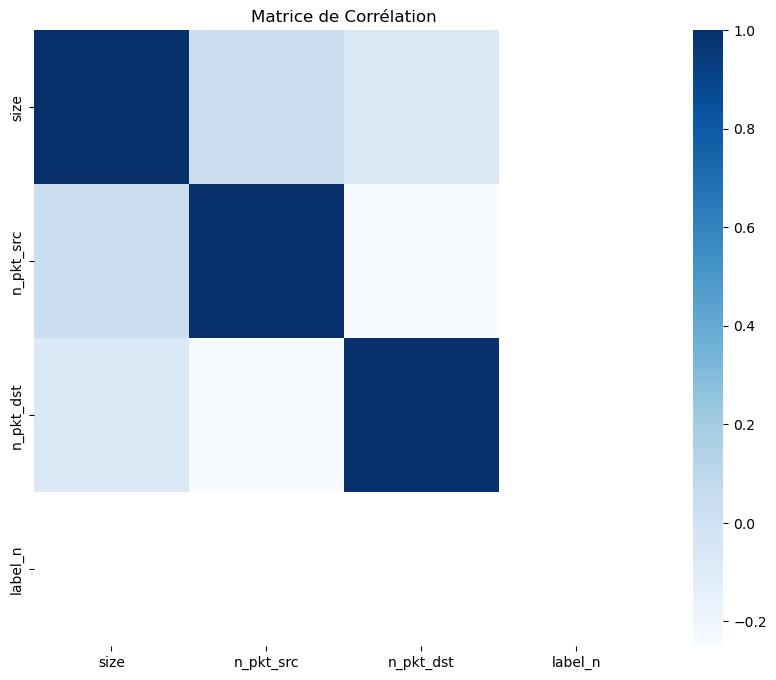

In [44]:
# The correlation matrix shouldn't be done on time as it is irrelevant and as it also conducts to an error
# It should also not be conducted on the numerical data like sport, dport, flags because they are "classes"
corr_matrix=reduce_data(data_fusion).loc[data_fusion['label']=='normal'][['size', 'n_pkt_src', 'n_pkt_dst', 'label_n']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='Blues')
plt.title("Matrice de Corrélation")
plt.show()

In [45]:
data_fusion_one_hot_encoded_and_normalized = pd.concat([data_fusion_numerical, data_fusion_one_hot_encoded], axis=1)
# Datasets provided in SVM should not contain one-hot encoded data
data_fusion_svm = pd.concat([data_fusion_numerical, data_fusion.copy().drop(columns=data_fusion_numerical.columns)], axis=1)

In [46]:
data_fusion_one_hot_encoded_and_normalized

size  n_pkt_src  n_pkt_dst  mac_s_00:0c:29:47:8c:0e  \
0        0.004127       0.00       0.00                    False   
1        0.003439       0.00       0.00                    False   
2        0.004127       0.01       0.00                    False   
3        0.003439       0.00       0.01                    False   
4        0.002751       0.00       0.02                    False   
...           ...        ...        ...                      ...   
1149929  0.000000       0.88       0.88                     True   
1149930  0.000000       0.88       0.88                     True   
1149931  0.000000       0.88       0.88                     True   
1149932  0.000000       0.88       0.88                     True   
1149933  0.000000       0.89       0.89                     True   

         mac_s_00:0c:29:47:8c:22  mac_s_00:80:f4:03:fb:12  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                     True   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_0a:fe:ec:47:74:fb  mac_s_4a:35:83:e0:3d:a4  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                    False   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_74:46:a0:bd:a7:1b  mac_s_e6:3f:ac:c9:a8:8c  ...  size_317  \
0                           True                    False  ...     False   
1                          False                    False  ...     False   
2                           True                    False  ...     False   
3                          False                     True  ...     False   
4                          False                    False  ...     False   
...                          ...                      ...  ...       ...   
1149929                    False                    False  ...     False   
1149930                    False                    False  ...     False   
1149931                    False                    False  ...     False   
1149932                    False                    False  ...     False   
1149933                    False                    False  ...     False   

         size_546  size_590  size_1433  size_1514  modbus_fn_Not specified  \
0           False     False      False      False                    False   
1           False     False      False      False                    False   
2           False     False      False      False                    False   
3           False     False      False      False                    False   
4           False     False      False      False                    False   
...           ...       ...        ...        ...                      ...   
1149929     False     False      False      False                     True   
1149930     False     False      False      False                     True   
1149931     False     False      False      False                     True   
1149932     False     False      Fals

In [47]:
data_fusion_svm

size  n_pkt_src  n_pkt_dst              mac_s              mac_d  \
0        0.004127       0.00       0.00  74:46:a0:bd:a7:1b  fa:00:bc:90:d7:fa   
1        0.003439       0.00       0.00  fa:00:bc:90:d7:fa  74:46:a0:bd:a7:1b   
2        0.004127       0.01       0.00  74:46:a0:bd:a7:1b  e6:3f:ac:c9:a8:8c   
3        0.003439       0.00       0.01  e6:3f:ac:c9:a8:8c  74:46:a0:bd:a7:1b   
4        0.002751       0.00       0.02  00:80:f4:03:fb:12  74:46:a0:bd:a7:1b   
...           ...        ...        ...                ...                ...   
1149929  0.000000       0.88       0.88  00:0c:29:47:8c:0e  00:80:f4:03:fb:12   
1149930  0.000000       0.88       0.88  00:0c:29:47:8c:0e  00:80:f4:03:fb:12   
1149931  0.000000       0.88       0.88  00:0c:29:47:8c:0e  00:80:f4:03:fb:12   
1149932  0.000000       0.88       0.88  00:0c:29:47:8c:0e  00:80:f4:03:fb:12   
1149933  0.000000       0.89       0.89  00:0c:29:47:8c:0e  00:80:f4:03:fb:12   

                 ip_s          ip_d    sport    dport   proto    flags  \
0         84.3.251.20  84.3.251.103  61516.0    502.0  Modbus  11000.0   
1        84.3.251.103   84.3.251.20    502.0  61516.0  Modbus  11000.0   
2         84.3.251.20  84.3.251.101  61515.0    502.0  Modbus  11000.0   
3        84.3.251.101   84.3.251.20    502.0  61515.0  Modbus  11000.0   
4         84.3.251.18   84.3.251.20    502.0  61514.0  Modbus  11000.0   
...               ...           ...      ...      ...     ...      ...   
1149929   84.3.251.20   84.3.251.18  26122.0    502.0     TCP     10.0   
1149930   84.3.251.20   84.3.251.18  26123.0    502.0     TCP     10.0   
1149931   84.3.251.20   84.3.251.18  26124.0    502.0     TCP     10.0   
1149932   84.3.251.20   84.3.251.18  26125.0    502.0     TCP     10.0   
1149933   84.3.251.20   84.3.251.18  26126.0    502.0     TCP     10.0   

                               modbus_fn  label_n   label  
0                 Read Holding Registers    False  normal  
1        Read Holding Registers Response    False  normal  
2                 Read Holding Registers    False  normal  
3        Read Holding Registers Response    False  normal  
4                    Read Coils Response    False  normal  
...                                  ...      ...     ...  
1149929                    Not specified     True     DoS  
1149930                    Not specified     True     DoS  
1149931                    Not specified     True     DoS  
1149932                    Not specified     True     DoS  
1149933                    Not specified     True     DoS  

[1149934 rows x 14 columns]

In [48]:
Y= data_fusion['label']
X= data_fusion_one_hot_encoded_and_normalized

# Y_train_SVM and Y_test_SVM contains the label not one-hot encoded because it doesn't needs it
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_test_svm=np.ravel(Y_test) 
Y_train_svm=np.ravel(Y_train)

Y_train= pd.get_dummies(Y_train, columns=['label'])
Y_test= pd.get_dummies(Y_test, columns=['label'])
DataSet={"X_train": X_train, "X_test":X_test, "Y_train":Y_train, "Y_test":Y_test,'Y_train_svm':Y_train_svm,'Y_test_svm':Y_test_svm}

In [49]:
X

size  n_pkt_src  n_pkt_dst  mac_s_00:0c:29:47:8c:0e  \
0        0.004127       0.00       0.00                    False   
1        0.003439       0.00       0.00                    False   
2        0.004127       0.01       0.00                    False   
3        0.003439       0.00       0.01                    False   
4        0.002751       0.00       0.02                    False   
...           ...        ...        ...                      ...   
1149929  0.000000       0.88       0.88                     True   
1149930  0.000000       0.88       0.88                     True   
1149931  0.000000       0.88       0.88                     True   
1149932  0.000000       0.88       0.88                     True   
1149933  0.000000       0.89       0.89                     True   

         mac_s_00:0c:29:47:8c:22  mac_s_00:80:f4:03:fb:12  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                     True   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_0a:fe:ec:47:74:fb  mac_s_4a:35:83:e0:3d:a4  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                    False   
...                          ...                      ...   
1149929                    False                    False   
1149930                    False                    False   
1149931                    False                    False   
1149932                    False                    False   
1149933                    False                    False   

         mac_s_74:46:a0:bd:a7:1b  mac_s_e6:3f:ac:c9:a8:8c  ...  size_317  \
0                           True                    False  ...     False   
1                          False                    False  ...     False   
2                           True                    False  ...     False   
3                          False                     True  ...     False   
4                          False                    False  ...     False   
...                          ...                      ...  ...       ...   
1149929                    False                    False  ...     False   
1149930                    False                    False  ...     False   
1149931                    False                    False  ...     False   
1149932                    False                    False  ...     False   
1149933                    False                    False  ...     False   

         size_546  size_590  size_1433  size_1514  modbus_fn_Not specified  \
0           False     False      False      False                    False   
1           False     False      False      False                    False   
2           False     False      False      False                    False   
3           False     False      False      False                    False   
4           False     False      False      False                    False   
...           ...       ...        ...        ...                      ...   
1149929     False     False      False      False                     True   
1149930     False     False      False      False                     True   
1149931     False     False      False      False                     True   
1149932     False     False      Fals

In [50]:
Y

0          normal
1          normal
2          normal
3          normal
4          normal
            ...  
1149929       DoS
1149930       DoS
1149931       DoS
1149932       DoS
1149933       DoS
Name: label, Length: 1149934, dtype: object

# Applying some algorithms

KNN, CART, Random Forrest, XGBoost, SVM, MLP (and additionnal ones if you want)

In [51]:
def one_hot_to_label(one_hot_array):
    return np.argmax(one_hot_array, axis=1)

def plot_confusion_matrix(y_true, y_pred, classes, is_svm=False):
    if not is_svm:
        y_true = one_hot_to_label(y_true)
        y_pred = one_hot_to_label(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    
    plt.title('Matrice de Confusion')
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')
    return plt
    
def plot_learning_curve_f1(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Courbes d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'apprentissage")
    plt.ylabel("F1 score")
    # Utiliser la fonction learning_curve avec le paramètre scoring='f1_micro' pour calculer le f1 score moyen sur chaque sous-ensemble
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="F1 score sur l'ensemble d'apprentissage")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="F1 score sur l'ensemble de validation croisée")
    plt.legend(loc="best")
    return plt

In [52]:
import time
import math

def Models(model, DataSet):
    resultat_model = {}
    
    start_fit = time.time()

    if model == 'cart':
        parameters = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
        Model_cart = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5)
        Model_cart.fit(DataSet['X_train'], DataSet['Y_train'])
        resultat_model['cart'] = Model_cart.best_estimator_

    elif model == 'xgb':
        parameters = {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200]}
        Model_XGBC = GridSearchCV(xgb.XGBClassifier(), parameters, cv=5)
        Model_XGBC.fit(DataSet['X_train'], DataSet['Y_train'])
        resultat_model['xgb'] = Model_XGBC.best_estimator_

    elif model == 'knn':
        parameters = {'n_neighbors': [3, 5, 7]}
        Model_knn = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
        Model_knn.fit(DataSet['X_train'], DataSet['Y_train'])
        resultat_model['knn'] = Model_knn.best_estimator_

    elif model == 'svm':
        Model_svm =SVC(kernel='poly', degree=5)
        Model_svm.fit(DataSet['X_train'],DataSet["Y_train_svm"])
        resultat_model['svm']=Model_svm
        
        
    elif model == 'mlp':
        parameters = {'hidden_layer_sizes': [(100,), (200,)]}
        Model_mlp = GridSearchCV(MLPClassifier(), parameters, cv=5)
        Model_mlp.fit(DataSet['X_train'], DataSet['Y_train'])
        resultat_model["mlp"] = Model_mlp.best_estimator_

    elif model == 'randomForest':
        parameters = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
        Model_rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
        Model_rf.fit(DataSet['X_train'], DataSet['Y_train'])
        resultat_model['randomForest'] = Model_rf.best_estimator_

    else:
        print("Le nom du modèle doit être compris dans cette liste : {cart, xgb, knn, svm, mlp, randomForest}")
    end_fit = time.time()
    elapsed_time = math.floor(end_fit - start_fit) + 1
    return resultat_model, elapsed_time


In [53]:
import json

if not os.path.exists('results'):
    os.makedirs('results/net/')

def evaluate_models(DataSet):
        
    sizes = [100, 1000, 10000, 100000]  
    label=['Label_DoS', 'Label_MITM', 'Label_normal', 'Label_physical fault', 'Label_anomaly', 'Label_scan']

    performance_results = {} # dictionnaire pour stocker les performances pour chaque modèle et chaque taille

    for size in sizes:
        subset_X_train = DataSet['X_train'][:size]
        subset_Y_train = DataSet['Y_train'][:size]
        subset_Y_train_svm = DataSet['Y_train_svm'][:size]

        # Création des modèles 
        print('\n')
        print('data SIZE:',size)
        print('\n')
        for model_type in ['cart', 'xgb', 'knn', 'randomForest', 'mlp', 'svm']:
                
            # Entraînez le modèle
            model_dict, fit_time = Models(model_type, {'X_train': subset_X_train, 'Y_train': subset_Y_train,'Y_train_svm': subset_Y_train_svm})
            model = model_dict[model_type]  # Accédez au modèle spécifique dans le dictionnaire
            
            #prédictions sur l'ensemble de test
            predictions = model.predict(DataSet['X_test'])

            start_predict = time.time()
            predictions = model.predict(DataSet['X_test'])
            end_predict = time.time()
            pred_time = math.floor(end_predict - start_predict) + 1
            
            print("FIT TIME")
            print(fit_time)
            print("PRED TIME")
            print(pred_time)

            print(f"{model_type}_size_{size}")

            image_path = "results/net/all/" + str(size) + "/" + model_type
            if not os.path.exists(image_path):
                os.makedirs(image_path)

            time_results = {
                "fit_time": fit_time,
                "pred_time": pred_time
            }
            
            with open(image_path + "/time.json", "w") as outfile: 
                json.dump(time_results, outfile)

            # Évaluez les performances  des modèles
            if model_type=="svm":
                
                accuracy = accuracy_score(DataSet['Y_test_svm'], predictions)
                print(f"{model_type}: Accuracy = {accuracy}")
                print('\n')

                report = classification_report(DataSet['Y_test_svm'], predictions, target_names=label, output_dict=True)
                sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
                plt.savefig(image_path + "/classification_report.png")

                plot_confusion_matrix(DataSet['Y_test_svm'], predictions, label, is_svm=True)
                plt.savefig(image_path + "/confusion_matrix.png")
                plt.show()
                
                plot_learning_curve_f1(model, subset_X_train, subset_Y_train_svm, cv=5)
                plt.savefig(image_path + "/f1_curve.png")
                plt.show()
            
            else:
                
                accuracy = accuracy_score(DataSet['Y_test'], predictions)
                print(f"{model_type}: Accuracy = {accuracy}")

                report = classification_report(DataSet['Y_test'], predictions, target_names=label, output_dict=True)
                sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
                plt.savefig(image_path + "/classification_report.png")
                
                plot_confusion_matrix(DataSet['Y_test'].to_numpy(),predictions, label)
                plt.savefig(image_path + "/confusion_matrix.png")
                plt.show()
                
                plot_learning_curve_f1(model, subset_X_train, subset_Y_train, cv=5)
                plt.savefig(image_path + "/f1_curve.png")
                plt.show()
        
                

            # Stockez les résultats dans le dictionnaire
            key = f"{model_type}_size_{size}"
            performance_results[key]=model_dict
            
    return performance_results


In [54]:
# evaluate_models(DataSet)